# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

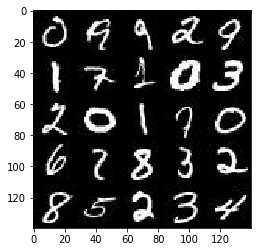

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

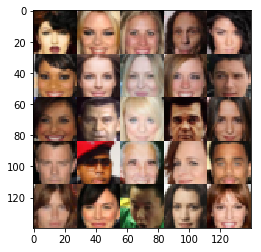

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    keep_prob = 0.7
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, keep_prob, training=True)
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, keep_prob, training=True)
        #7x7x128
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, keep_prob, training=True)
        #7x7x256
        
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    z_dim = tf.shape(z)
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*128)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1, filters=64, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x64
        
        x3 = tf.layers.conv2d_transpose(x2, filters=32, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x32
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        #28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    import pickle as pkl
    
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    n_images = 4
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2835... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.1577
Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 2.0538
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 2.0337... Generator Loss: 1.3412
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 1.6425
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 1.6354


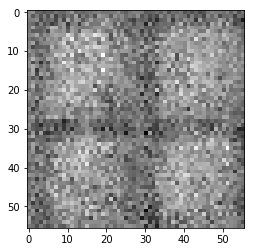

Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.2849
Epoch 1/2... Discriminator Loss: 2.2206... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 2.3858... Generator Loss: 1.0546
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 1.3706
Epoch 1/2... Discriminator Loss: 1.8517... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.7077
Epoch 1/2... Discriminator Loss: 0.5806... Generator Loss: 2.1827
Epoch 1/2... Discriminator Loss: 0.6080... Generator Loss: 2.2822
Epoch 1/2... Discriminator Loss: 0.6538... Generator Loss: 1.3770


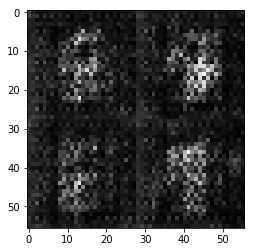

Epoch 1/2... Discriminator Loss: 0.7598... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 0.6002... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 2.4940
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 2.2678... Generator Loss: 1.5228
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 1.4362
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.7304


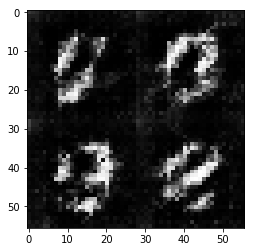

Epoch 1/2... Discriminator Loss: 2.1883... Generator Loss: 2.1591
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.2332
Epoch 1/2... Discriminator Loss: 2.3364... Generator Loss: 2.0629
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 1.6317... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 2.2058... Generator Loss: 1.5058
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.4545


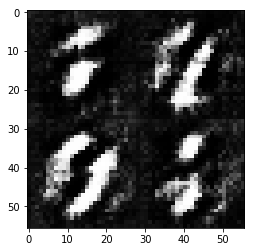

Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.2977
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 1.7829
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 1.7182
Epoch 1/2... Discriminator Loss: 1.6763... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 2.1142
Epoch 1/2... Discriminator Loss: 2.1825... Generator Loss: 2.4217


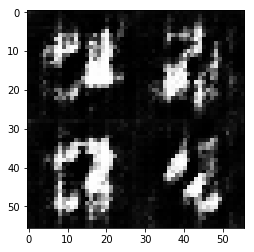

Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.6769
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 2.4662... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 2.6524... Generator Loss: 1.4453
Epoch 1/2... Discriminator Loss: 1.9842... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 0.4560
Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.9047
Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 1.8809
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.5395... Generator Loss: 0.4882


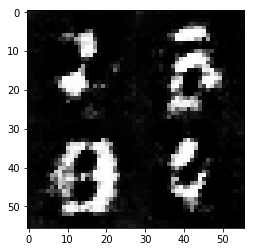

Epoch 1/2... Discriminator Loss: 2.6997... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 2.1842... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.9294... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 1.1278
Epoch 1/2... Discriminator Loss: 1.7706... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.6821... Generator Loss: 1.4823
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.6656... Generator Loss: 0.1696
Epoch 1/2... Discriminator Loss: 2.1631... Generator Loss: 2.0020


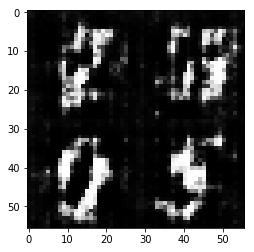

Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 2.9869
Epoch 1/2... Discriminator Loss: 1.8647... Generator Loss: 2.5282
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.1723
Epoch 1/2... Discriminator Loss: 2.1967... Generator Loss: 0.9377
Epoch 1/2... Discriminator Loss: 1.9607... Generator Loss: 0.4138
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.5634
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.5141
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 2.1481
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 1.1513


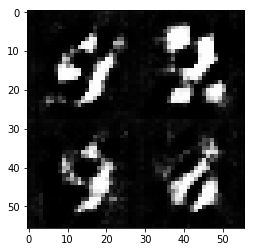

Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.8445
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 1.0494
Epoch 1/2... Discriminator Loss: 1.7976... Generator Loss: 1.8793
Epoch 1/2... Discriminator Loss: 2.1406... Generator Loss: 1.3078
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.3938
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 2.0916
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 0.2611
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 1.3924


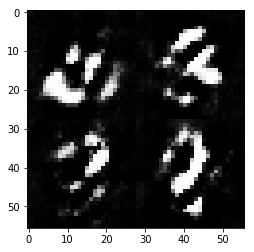

Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 1.8870... Generator Loss: 1.2968
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 0.3568
Epoch 1/2... Discriminator Loss: 1.9977... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 2.1444... Generator Loss: 1.3562
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 1.1891
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.9535
Epoch 1/2... Discriminator Loss: 2.0106... Generator Loss: 1.4470


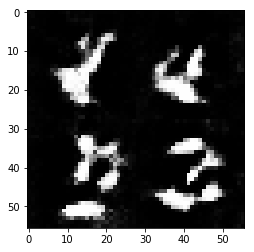

Epoch 1/2... Discriminator Loss: 1.8604... Generator Loss: 0.3813
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 0.3291
Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 2.4345
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 1.7292
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 1.8908
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 1.6117
Epoch 1/2... Discriminator Loss: 1.9573... Generator Loss: 0.8708


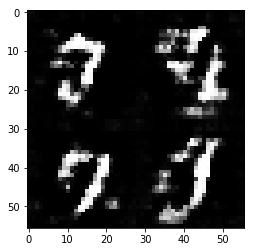

Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 2.1755
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 1.2765
Epoch 1/2... Discriminator Loss: 1.7522... Generator Loss: 1.5867
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 2.1645... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 1.4640
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.6566
Epoch 1/2... Discriminator Loss: 1.5496... Generator Loss: 1.4243
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.1614


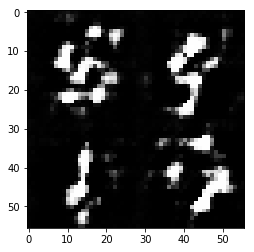

Epoch 1/2... Discriminator Loss: 2.5539... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 1.7725... Generator Loss: 1.3120
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 1.6015
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 1.0649
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.4770
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 1.3217
Epoch 1/2... Discriminator Loss: 1.5516... Generator Loss: 0.4675


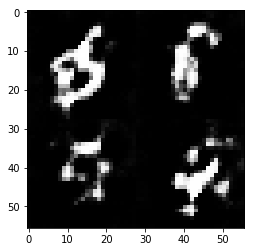

Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 0.3934... Generator Loss: 1.3700
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 1.4744
Epoch 1/2... Discriminator Loss: 0.8736... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.1811
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.7957
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 1.1416


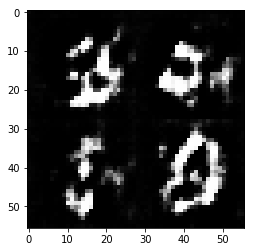

Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.1457
Epoch 1/2... Discriminator Loss: 1.9411... Generator Loss: 0.5151
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 1.6290
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 1.6413
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 1.8480
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 1.3452


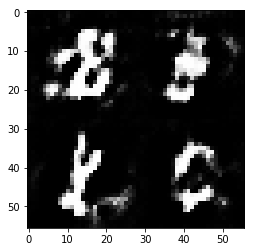

Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 1.9846
Epoch 1/2... Discriminator Loss: 0.9077... Generator Loss: 2.2065
Epoch 1/2... Discriminator Loss: 1.8280... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.0704
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.7074
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 2.1201
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 1.6992
Epoch 1/2... Discriminator Loss: 0.5021... Generator Loss: 3.3177
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.4843


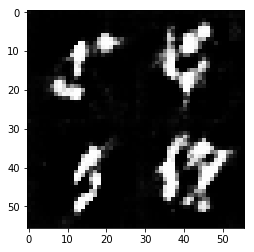

Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 1.8205
Epoch 1/2... Discriminator Loss: 1.8330... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.5046
Epoch 1/2... Discriminator Loss: 0.6129... Generator Loss: 1.4525
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 1.5684
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 2.3653
Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 1.6513
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.4988


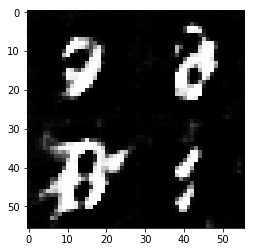

Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 1.7678
Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 2.3029
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.7887... Generator Loss: 0.2150
Epoch 1/2... Discriminator Loss: 0.5108... Generator Loss: 1.1436
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.4556
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.4431


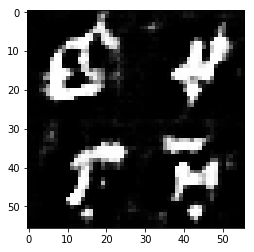

Epoch 1/2... Discriminator Loss: 1.4839... Generator Loss: 0.4553
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.0744
Epoch 1/2... Discriminator Loss: 1.8852... Generator Loss: 2.0163
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 2.0905... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.2925
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 2.0267... Generator Loss: 1.8916
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.7953
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 1.8710


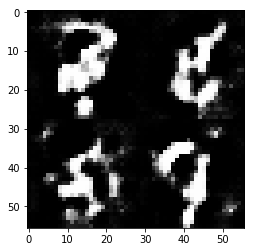

Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 2.5239
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 1.9802
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 0.5130... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.3227... Generator Loss: 2.7942
Epoch 1/2... Discriminator Loss: 1.8206... Generator Loss: 1.9157
Epoch 1/2... Discriminator Loss: 0.3310... Generator Loss: 1.8682
Epoch 1/2... Discriminator Loss: 2.0366... Generator Loss: 0.7651


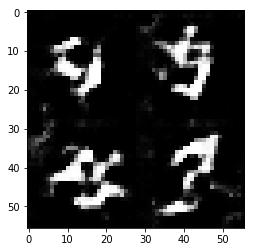

Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 0.2041
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 2.7507... Generator Loss: 2.5672
Epoch 1/2... Discriminator Loss: 1.8917... Generator Loss: 2.5759
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.2876
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.8257... Generator Loss: 2.8798
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 2.1205


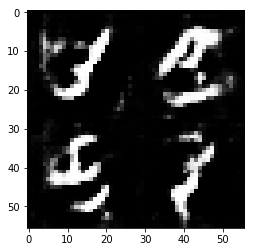

Epoch 1/2... Discriminator Loss: 0.4357... Generator Loss: 0.4167
Epoch 1/2... Discriminator Loss: 2.0072... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 1.0199
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.6908
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 1.4056
Epoch 1/2... Discriminator Loss: 1.5516... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 2.3206
Epoch 1/2... Discriminator Loss: 2.4465... Generator Loss: 1.1649
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 0.1426
Epoch 1/2... Discriminator Loss: 1.8903... Generator Loss: 1.6612


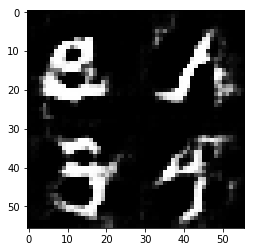

Epoch 1/2... Discriminator Loss: 2.2888... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 1.1734
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 1.2315
Epoch 1/2... Discriminator Loss: 1.6756... Generator Loss: 2.5351
Epoch 1/2... Discriminator Loss: 0.6661... Generator Loss: 1.8020
Epoch 1/2... Discriminator Loss: 2.9851... Generator Loss: 1.9042
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 0.9076
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.1412
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.0486


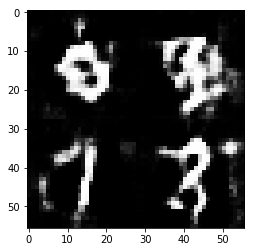

Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 1.6176
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 2.3601
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 1.9423
Epoch 1/2... Discriminator Loss: 1.6518... Generator Loss: 2.3327
Epoch 1/2... Discriminator Loss: 2.4503... Generator Loss: 1.2154
Epoch 1/2... Discriminator Loss: 1.8803... Generator Loss: 1.7379
Epoch 1/2... Discriminator Loss: 0.6643... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.9283
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.3209


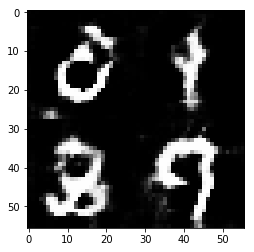

Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.4968
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 0.5884... Generator Loss: 1.2593
Epoch 1/2... Discriminator Loss: 0.2958... Generator Loss: 2.1517
Epoch 1/2... Discriminator Loss: 1.6744... Generator Loss: 1.6024
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 1.0911
Epoch 1/2... Discriminator Loss: 1.9163... Generator Loss: 1.5658
Epoch 1/2... Discriminator Loss: 1.6754... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.1599... Generator Loss: 1.2148


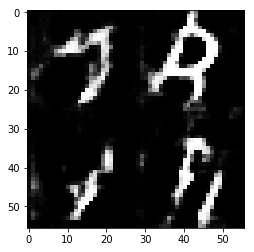

Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.7649
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 0.4162... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 1.2008
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 1.9989
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 1.2106


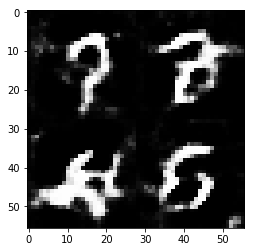

Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 3.9610
Epoch 1/2... Discriminator Loss: 2.3832... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 2.3735... Generator Loss: 1.7113
Epoch 1/2... Discriminator Loss: 1.8951... Generator Loss: 1.1789
Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 2.1709
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 2.1306
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 1.7720
Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 0.6322


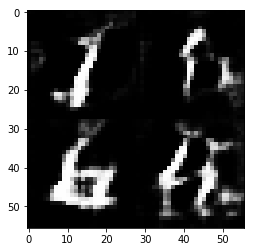

Epoch 1/2... Discriminator Loss: 0.4818... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 2.2160
Epoch 1/2... Discriminator Loss: 2.4620... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.1997
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 1.9912
Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 2.3431
Epoch 1/2... Discriminator Loss: 1.5395... Generator Loss: 2.0028
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.4996
Epoch 1/2... Discriminator Loss: 1.9942... Generator Loss: 0.4491


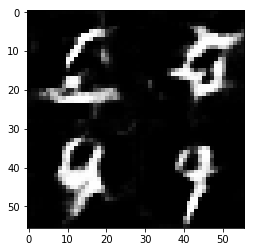

Epoch 1/2... Discriminator Loss: 1.8833... Generator Loss: 2.5716
Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 1.7279
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 1.8711
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 1.5605... Generator Loss: 0.5217
Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 0.1569
Epoch 1/2... Discriminator Loss: 1.5406... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.2976
Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 0.2699
Epoch 1/2... Discriminator Loss: 2.3272... Generator Loss: 1.8772


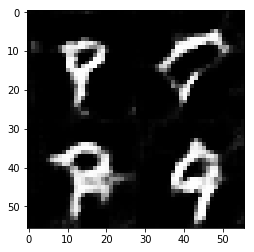

Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 1.4137
Epoch 1/2... Discriminator Loss: 1.7679... Generator Loss: 0.3149
Epoch 1/2... Discriminator Loss: 1.6318... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 2.7626... Generator Loss: 1.3308
Epoch 1/2... Discriminator Loss: 2.1388... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 1.4374
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.4890


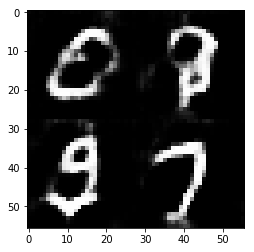

Epoch 1/2... Discriminator Loss: 2.3682... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 3.0594... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 1.7850... Generator Loss: 1.5917
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 1.1075
Epoch 1/2... Discriminator Loss: 1.9344... Generator Loss: 3.3441
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 1.8967
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.2495
Epoch 1/2... Discriminator Loss: 1.8812... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 1.3091


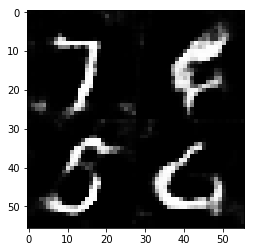

Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.4003
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.8084
Epoch 1/2... Discriminator Loss: 1.7510... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 1.6018
Epoch 1/2... Discriminator Loss: 2.0182... Generator Loss: 1.7338
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 1.3785
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 0.5427
Epoch 1/2... Discriminator Loss: 2.1973... Generator Loss: 0.5830


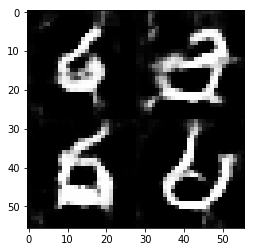

Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.8687... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 1.8340
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.7532
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.7598
Epoch 1/2... Discriminator Loss: 2.0825... Generator Loss: 1.1668
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 2.7376... Generator Loss: 0.7324


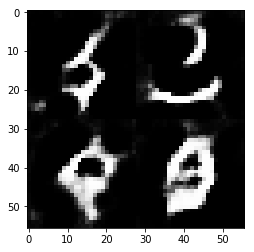

Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.6350
Epoch 1/2... Discriminator Loss: 3.2915... Generator Loss: 0.2696
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 1.9750... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.4456
Epoch 1/2... Discriminator Loss: 2.5994... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 2.2308
Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 1.5564
Epoch 1/2... Discriminator Loss: 2.6837... Generator Loss: 0.2066
Epoch 1/2... Discriminator Loss: 0.2477... Generator Loss: 1.3926


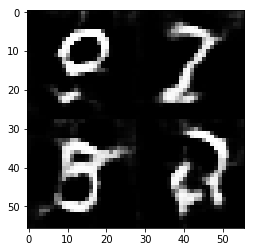

Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.8958
Epoch 1/2... Discriminator Loss: 2.1330... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 1.7660
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 1.6966
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.4792
Epoch 1/2... Discriminator Loss: 1.8880... Generator Loss: 1.0943
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 0.5754
Epoch 1/2... Discriminator Loss: 1.7364... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 2.1271... Generator Loss: 1.4064


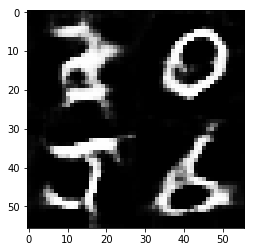

Epoch 1/2... Discriminator Loss: 2.0247... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.5607
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 1.1227
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 0.9790
Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 1.8183
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 2.0956... Generator Loss: 0.1476
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 1.3397
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.0462


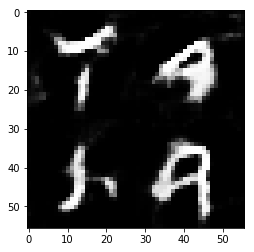

Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 1.5950
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.6852... Generator Loss: 1.3624
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 1.8029
Epoch 1/2... Discriminator Loss: 0.4959... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 1.4043
Epoch 1/2... Discriminator Loss: 2.3150... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 1.7676... Generator Loss: 1.4558
Epoch 1/2... Discriminator Loss: 2.0081... Generator Loss: 1.3468
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.2207


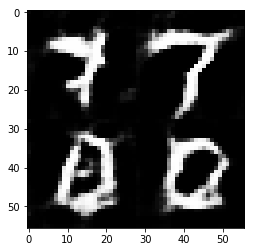

Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 1.0290
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.5181
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 2.1206
Epoch 1/2... Discriminator Loss: 2.0733... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 1.9453
Epoch 1/2... Discriminator Loss: 1.8978... Generator Loss: 1.1166


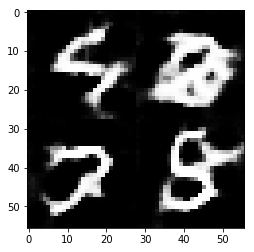

Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 1.4388
Epoch 1/2... Discriminator Loss: 2.5655... Generator Loss: 0.3199
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 1.5073
Epoch 1/2... Discriminator Loss: 2.5544... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.6648
Epoch 1/2... Discriminator Loss: 2.8906... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 1.1946


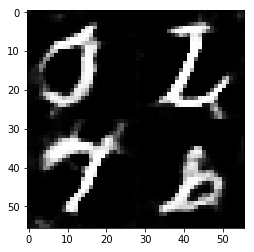

Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 1.7511... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.5118... Generator Loss: 0.4384
Epoch 1/2... Discriminator Loss: 2.3138... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.7339
Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 1.3566
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.2587
Epoch 1/2... Discriminator Loss: 2.7841... Generator Loss: 1.3300
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.9136... Generator Loss: 1.4797


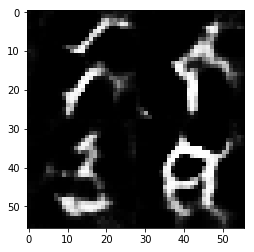

Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 2.1404... Generator Loss: 0.6470
Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 1.9543
Epoch 1/2... Discriminator Loss: 0.5155... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 2.2502... Generator Loss: 0.9619
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 2.5025... Generator Loss: 1.3659
Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 1.4338
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 0.9915


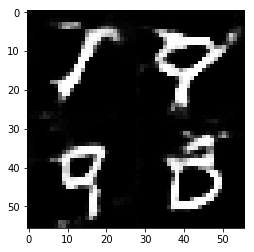

Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 1.2537
Epoch 1/2... Discriminator Loss: 2.4258... Generator Loss: 1.3430
Epoch 1/2... Discriminator Loss: 3.4164... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 2.0691... Generator Loss: 1.3547
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.2005
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.6950
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 1.0724
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 1.5947


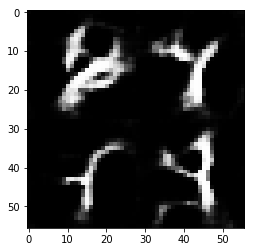

Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 1.1668
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.4291
Epoch 1/2... Discriminator Loss: 1.8169... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 0.5493
Epoch 1/2... Discriminator Loss: 1.8499... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.6212


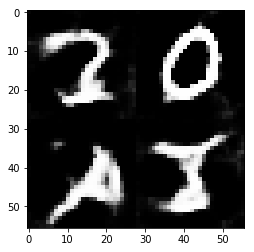

Epoch 1/2... Discriminator Loss: 1.7326... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 2.2104... Generator Loss: 1.0495
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.2746
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 2.1892... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 2.1097... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 1.8762... Generator Loss: 1.0431
Epoch 1/2... Discriminator Loss: 1.7561... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 2.2149... Generator Loss: 0.8852


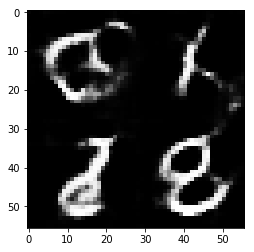

Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.9492... Generator Loss: 0.4625
Epoch 1/2... Discriminator Loss: 0.8142... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 1.8802... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 0.4210... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 2.4962... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.6886... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 0.5934... Generator Loss: 2.1992
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.2491
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.1135


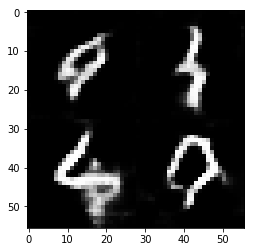

Epoch 1/2... Discriminator Loss: 1.7035... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.6792... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.9964
Epoch 1/2... Discriminator Loss: 2.0641... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 1.5515
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.4853
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 2.9950
Epoch 1/2... Discriminator Loss: 1.9270... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 1.4021


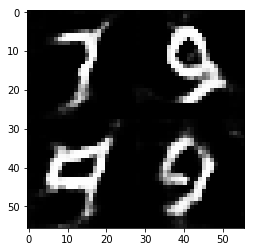

Epoch 1/2... Discriminator Loss: 2.8203... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 2.3163... Generator Loss: 1.3807
Epoch 1/2... Discriminator Loss: 2.0096... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 1.5403
Epoch 1/2... Discriminator Loss: 1.6867... Generator Loss: 1.1622
Epoch 1/2... Discriminator Loss: 2.1156... Generator Loss: 1.5170
Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 2.9763... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 2.2393
Epoch 1/2... Discriminator Loss: 0.4973... Generator Loss: 0.9471


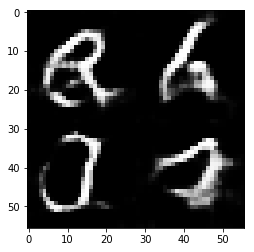

Epoch 1/2... Discriminator Loss: 1.7704... Generator Loss: 1.2420
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 2.4366... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 1.1544
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.2429
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.4929


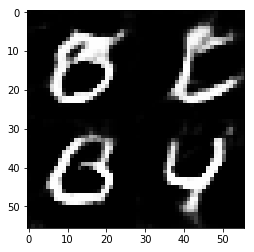

Epoch 1/2... Discriminator Loss: 2.2699... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.4304
Epoch 1/2... Discriminator Loss: 1.6714... Generator Loss: 1.3349
Epoch 1/2... Discriminator Loss: 1.7204... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.9713
Epoch 1/2... Discriminator Loss: 1.8939... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 2.1072... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 0.2863... Generator Loss: 1.7060


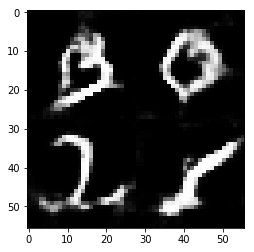

Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.7402... Generator Loss: 1.1523
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 1.1693
Epoch 1/2... Discriminator Loss: 1.8664... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 2.5340... Generator Loss: 0.5006
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.4628
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 1.4253


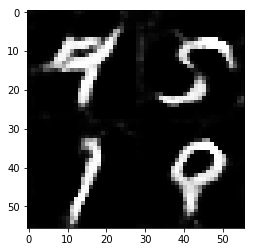

Epoch 1/2... Discriminator Loss: 1.6529... Generator Loss: 0.6025
Epoch 1/2... Discriminator Loss: 1.1395... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 0.5257... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.9441... Generator Loss: 1.2158
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 2.0446
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.6967


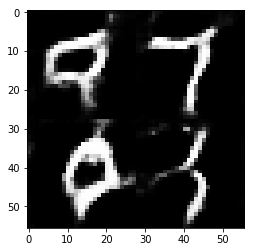

Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 2.8065
Epoch 1/2... Discriminator Loss: 3.3392... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.3347
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.5989
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.9498... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 1.5071... Generator Loss: 1.5546


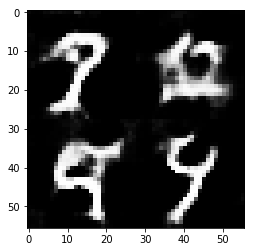

Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.5479... Generator Loss: 1.7909
Epoch 1/2... Discriminator Loss: 1.1602... Generator Loss: 0.2898
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.9440
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 1.4813
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 1.0859
Epoch 1/2... Discriminator Loss: 0.6512... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.0714


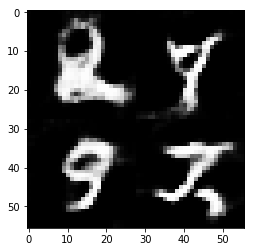

Epoch 1/2... Discriminator Loss: 2.3409... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 1.0410
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 1.7111... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 2.3444
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 2.8274... Generator Loss: 1.2005
Epoch 1/2... Discriminator Loss: 2.1857... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 1.6378... Generator Loss: 0.5878


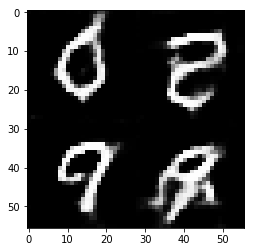

Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 1.3094
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 0.9073
Epoch 1/2... Discriminator Loss: 1.8090... Generator Loss: 2.3051
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.2401
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 1.8545... Generator Loss: 1.2622
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.2514


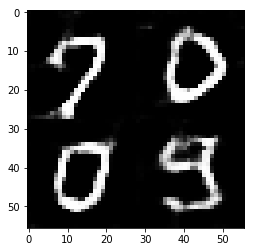

Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 2.5478... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 2.8058
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 1.1387
Epoch 1/2... Discriminator Loss: 1.6920... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.4747
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 1.5917
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.7544


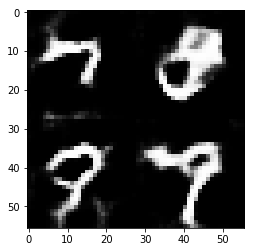

Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 1.8433... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 2.2408
Epoch 1/2... Discriminator Loss: 1.5154... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 1.4393
Epoch 1/2... Discriminator Loss: 1.9871... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.5779... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.8537... Generator Loss: 0.9551
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 2.4137... Generator Loss: 1.6036


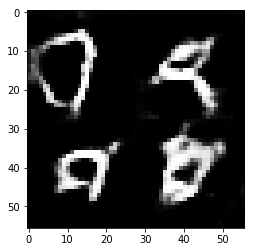

Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 0.5314... Generator Loss: 1.5493
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.7506
Epoch 1/2... Discriminator Loss: 1.0296... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 2.3060
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 2.2240... Generator Loss: 0.4497
Epoch 1/2... Discriminator Loss: 1.7617... Generator Loss: 0.8404


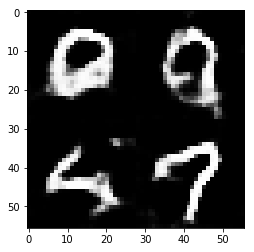

Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.7439... Generator Loss: 1.2784
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 1.3391
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 1.5046
Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 1.7343... Generator Loss: 1.3695
Epoch 1/2... Discriminator Loss: 2.3516... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 0.7473... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 2.3649


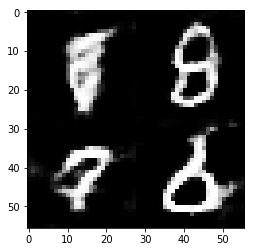

Epoch 1/2... Discriminator Loss: 2.3580... Generator Loss: 0.4578
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 1.5987... Generator Loss: 1.1918
Epoch 1/2... Discriminator Loss: 1.5336... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 1.2997
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 1.7174
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 1.2980
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.6802


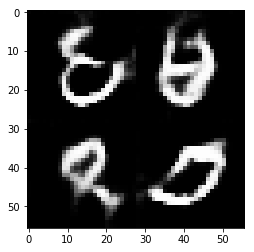

Epoch 2/2... Discriminator Loss: 2.1529... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.9750... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 1.8600... Generator Loss: 1.3231
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 2.9157... Generator Loss: 0.4043
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 2.0389
Epoch 2/2... Discriminator Loss: 0.5738... Generator Loss: 1.2578


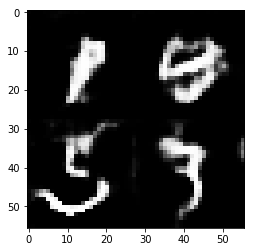

Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 1.1628
Epoch 2/2... Discriminator Loss: 2.2946... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 2.1555... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 0.9642... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.4577... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.4640
Epoch 2/2... Discriminator Loss: 2.2998... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.9135... Generator Loss: 0.9892


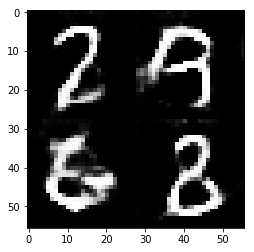

Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 1.9845... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 1.4839
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 2.0083
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.7044... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 0.4738


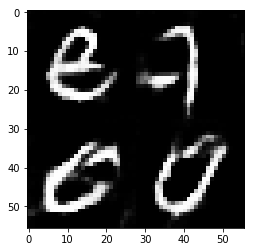

Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.7946... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.7013... Generator Loss: 0.1861
Epoch 2/2... Discriminator Loss: 1.9226... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 2.2262... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.8322


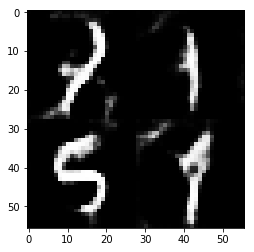

Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 1.6957... Generator Loss: 2.3064
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 2.9167
Epoch 2/2... Discriminator Loss: 1.4979... Generator Loss: 0.8021
Epoch 2/2... Discriminator Loss: 1.8621... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.0901
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 0.3876
Epoch 2/2... Discriminator Loss: 1.8426... Generator Loss: 1.3090


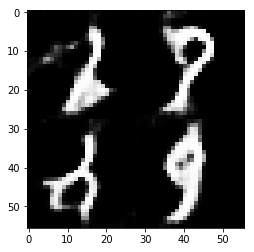

Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 2.2551
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 1.5717... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.9262... Generator Loss: 1.4684
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 1.2849
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 0.9083


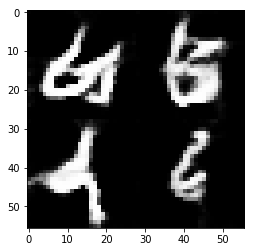

Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 1.2625
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.1640
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 2.2393
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 1.0892
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 2.1325
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 0.4930
Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0816


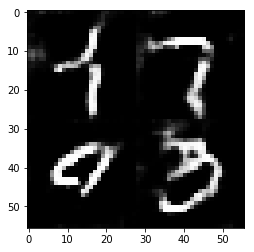

Epoch 2/2... Discriminator Loss: 2.8790... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 1.3594
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 0.6615
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.6624... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 1.4728
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.6536... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 1.4775... Generator Loss: 1.3641


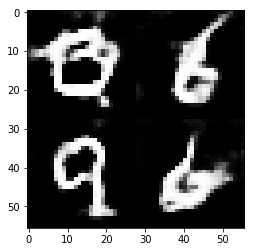

Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.5408... Generator Loss: 0.4663
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 1.1413
Epoch 2/2... Discriminator Loss: 1.7565... Generator Loss: 2.0103
Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 2.1117... Generator Loss: 0.5069
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 1.8783
Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 1.9623
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.9061


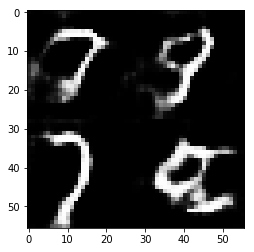

Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.9002
Epoch 2/2... Discriminator Loss: 1.8028... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.4902
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.2987... Generator Loss: 0.3906
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.8874
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 2.4651
Epoch 2/2... Discriminator Loss: 2.0594... Generator Loss: 1.2106


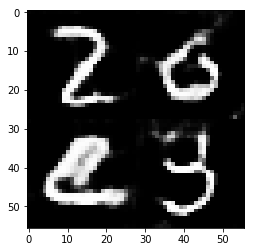

Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 2.1752
Epoch 2/2... Discriminator Loss: 1.6318... Generator Loss: 1.9441
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.7262
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 1.3075
Epoch 2/2... Discriminator Loss: 2.6470... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 0.4772
Epoch 2/2... Discriminator Loss: 1.9599... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.6344... Generator Loss: 1.5530


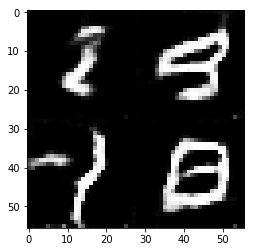

Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 1.1199
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 1.6921
Epoch 2/2... Discriminator Loss: 1.5322... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 2.3798... Generator Loss: 0.4707
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.2438
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 1.2023


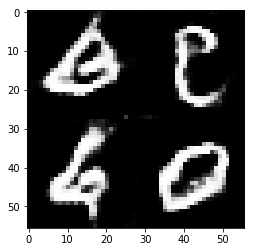

Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 1.9617
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 1.6458
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.4431
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 2.2914
Epoch 2/2... Discriminator Loss: 1.9279... Generator Loss: 1.6961
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 1.6352
Epoch 2/2... Discriminator Loss: 0.6502... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 1.7631... Generator Loss: 0.8415


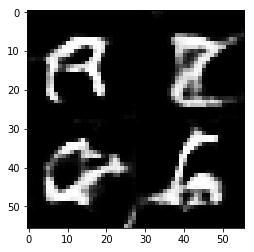

Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 1.9770
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.3925
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 1.4786
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 1.3869
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 1.9912
Epoch 2/2... Discriminator Loss: 2.0232... Generator Loss: 0.9228


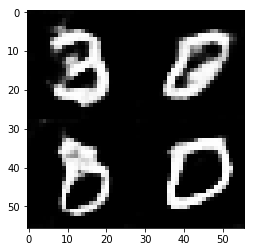

Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 0.9162
Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 1.7456
Epoch 2/2... Discriminator Loss: 1.5941... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 1.8620... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 2.5809... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.9431... Generator Loss: 0.4262
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 0.3264
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.8911


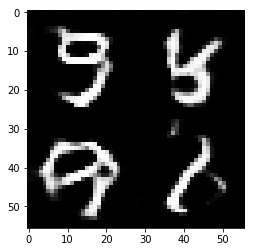

Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 2.2624
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 0.4335
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 1.4573
Epoch 2/2... Discriminator Loss: 1.8970... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 2.1372
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.9442
Epoch 2/2... Discriminator Loss: 2.9910... Generator Loss: 0.6011
Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 1.1191
Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 1.1350


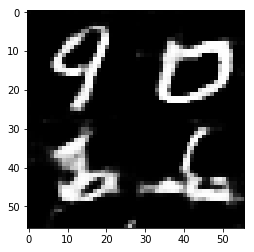

Epoch 2/2... Discriminator Loss: 1.8772... Generator Loss: 1.7925
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.8797... Generator Loss: 1.2125
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 2.1491... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 0.6057... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 1.9816
Epoch 2/2... Discriminator Loss: 1.7266... Generator Loss: 0.4871
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 1.0474


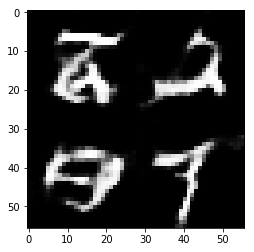

Epoch 2/2... Discriminator Loss: 1.7139... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.7653... Generator Loss: 1.5717
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.6618... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 0.5628... Generator Loss: 1.3632
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.8798
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 1.3233
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.9365


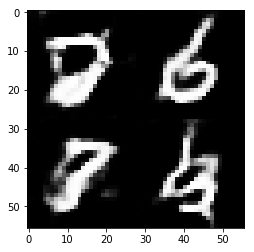

Epoch 2/2... Discriminator Loss: 0.7654... Generator Loss: 1.2482
Epoch 2/2... Discriminator Loss: 1.9116... Generator Loss: 1.6057
Epoch 2/2... Discriminator Loss: 1.7452... Generator Loss: 1.3155
Epoch 2/2... Discriminator Loss: 1.8310... Generator Loss: 1.1028
Epoch 2/2... Discriminator Loss: 2.7884... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 1.0071
Epoch 2/2... Discriminator Loss: 1.1633... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 1.6703
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.8244


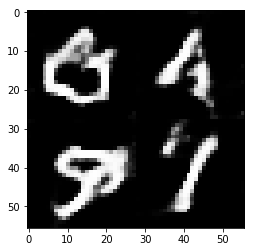

Epoch 2/2... Discriminator Loss: 0.6714... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 1.6048... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 1.8696
Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 1.7018
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 1.6502
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 1.7087
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.5762


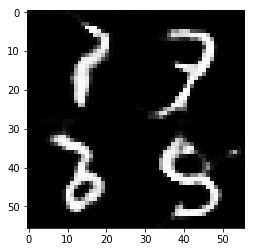

Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.5050
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 2.3698
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 1.6290
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 1.0354
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 1.5751... Generator Loss: 1.3110
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 1.3686


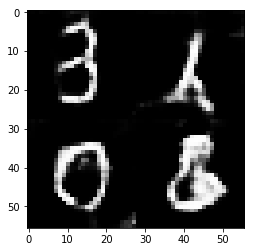

Epoch 2/2... Discriminator Loss: 0.7130... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 0.4111
Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 1.5906... Generator Loss: 1.2705
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 2.4995... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 2.7405
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 1.0290


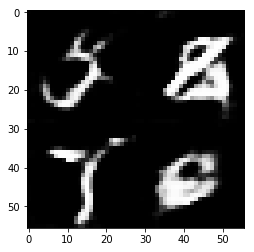

Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 2.3911
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.6508
Epoch 2/2... Discriminator Loss: 1.6546... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 1.3964
Epoch 2/2... Discriminator Loss: 1.6805... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 1.6241... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 0.3418... Generator Loss: 1.6514
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.2047
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 1.5077


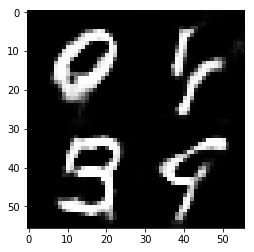

Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 0.3074
Epoch 2/2... Discriminator Loss: 1.6436... Generator Loss: 2.5463
Epoch 2/2... Discriminator Loss: 1.8062... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 1.2913
Epoch 2/2... Discriminator Loss: 2.2788... Generator Loss: 1.8488
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.5591... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 1.1594
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.4848


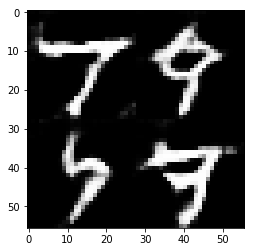

Epoch 2/2... Discriminator Loss: 2.0263... Generator Loss: 1.8074
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 2.0544... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.8357... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 1.7208
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 1.6356
Epoch 2/2... Discriminator Loss: 1.6728... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 2.6450... Generator Loss: 1.0273
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.4467


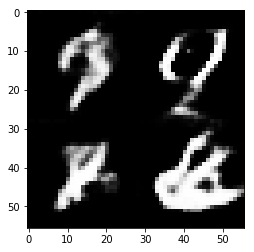

Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 1.7621... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.9213... Generator Loss: 1.8148
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 0.6415... Generator Loss: 0.8107


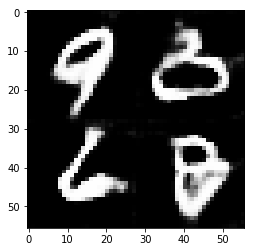

Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 1.0370
Epoch 2/2... Discriminator Loss: 1.4979... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.3394
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.5473
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 1.7132
Epoch 2/2... Discriminator Loss: 1.6357... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 2.1748... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.8903
Epoch 2/2... Discriminator Loss: 1.7207... Generator Loss: 2.2731


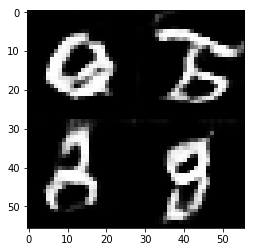

Epoch 2/2... Discriminator Loss: 1.8298... Generator Loss: 1.3536
Epoch 2/2... Discriminator Loss: 2.3975... Generator Loss: 0.5855
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 1.8870... Generator Loss: 0.2902
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.5588
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.7760
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.6178
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 2.3370
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 1.3612
Epoch 2/2... Discriminator Loss: 1.5989... Generator Loss: 1.2481


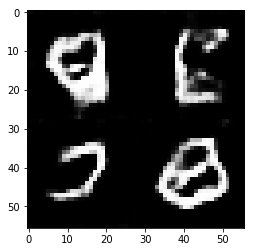

Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 2.1595
Epoch 2/2... Discriminator Loss: 2.5872... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 2.5897... Generator Loss: 1.6064
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 2.3248... Generator Loss: 1.5616
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.7005
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.8975


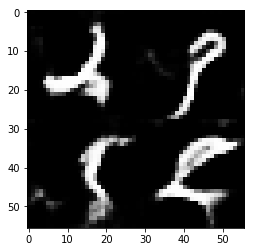

Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.3265
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 1.1817
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 1.5882
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.4410
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.4456
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.6873


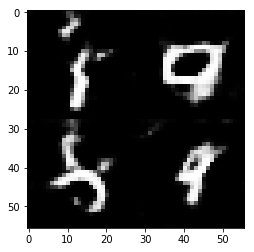

Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 0.3661... Generator Loss: 1.6826
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 2.1480
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.7627
Epoch 2/2... Discriminator Loss: 2.2748... Generator Loss: 0.5218
Epoch 2/2... Discriminator Loss: 1.5461... Generator Loss: 1.6631
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 1.8866
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.6793


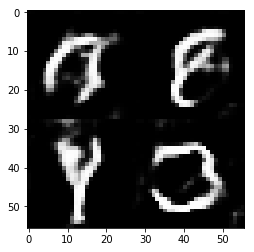

Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 1.9623... Generator Loss: 1.6302
Epoch 2/2... Discriminator Loss: 1.9375... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 1.8088... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 0.7975
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 1.8385
Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 0.6683


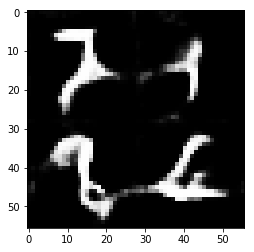

Epoch 2/2... Discriminator Loss: 2.6515... Generator Loss: 1.9654
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 1.5405
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.5807
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 1.8001
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 1.6530
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 0.3636


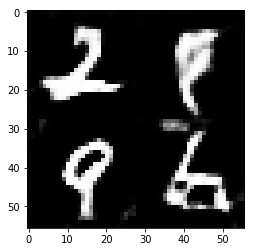

Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.5560
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 1.2967
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.7508
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 3.6433
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.4000
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 1.6482
Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 1.1155
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 1.0470


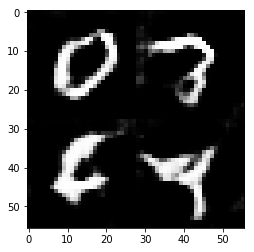

Epoch 2/2... Discriminator Loss: 1.6512... Generator Loss: 0.3571
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 1.2139
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 1.1648
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 1.4486
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 0.6786


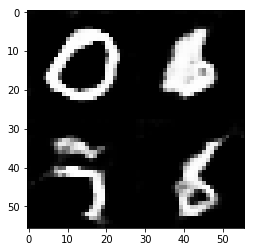

Epoch 2/2... Discriminator Loss: 1.5313... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 1.2596
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 2.2289
Epoch 2/2... Discriminator Loss: 2.0377... Generator Loss: 0.4774
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 1.1592
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 0.3493
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 0.8934
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 0.6647


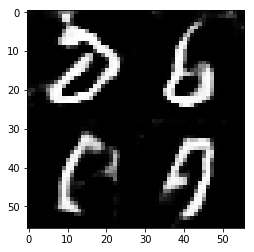

Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.2581
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.8028... Generator Loss: 0.5438
Epoch 2/2... Discriminator Loss: 2.3320... Generator Loss: 0.6174
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 1.1265
Epoch 2/2... Discriminator Loss: 1.9480... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.8988
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.0120


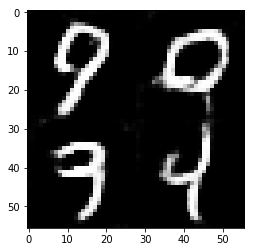

Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 2.1366... Generator Loss: 0.8540
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.7636
Epoch 2/2... Discriminator Loss: 1.9537... Generator Loss: 1.1132
Epoch 2/2... Discriminator Loss: 1.7604... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.9525
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.5801


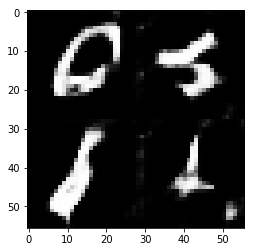

Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.2909
Epoch 2/2... Discriminator Loss: 1.7776... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 0.5127... Generator Loss: 1.8015
Epoch 2/2... Discriminator Loss: 1.9225... Generator Loss: 1.7388
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.9885
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 1.7666


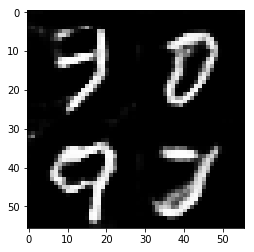

Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 0.8004
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.8591
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.6363
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 1.3200
Epoch 2/2... Discriminator Loss: 2.1276... Generator Loss: 1.3607
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 2.6447... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 1.9681
Epoch 2/2... Discriminator Loss: 2.6241... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 1.6570... Generator Loss: 1.7997


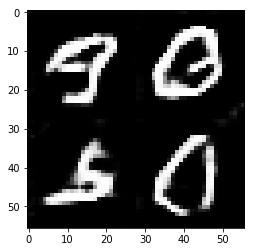

Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 1.6273
Epoch 2/2... Discriminator Loss: 1.6186... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 1.0632
Epoch 2/2... Discriminator Loss: 1.9825... Generator Loss: 2.1683
Epoch 2/2... Discriminator Loss: 1.6621... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.5799... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 1.2907
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 0.6949


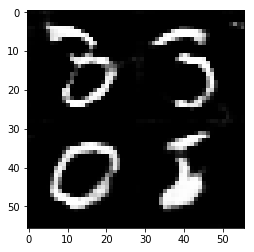

Epoch 2/2... Discriminator Loss: 2.1111... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 1.5904... Generator Loss: 0.4414
Epoch 2/2... Discriminator Loss: 1.7049... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 1.4037
Epoch 2/2... Discriminator Loss: 1.4931... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 2.3617... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 1.0597


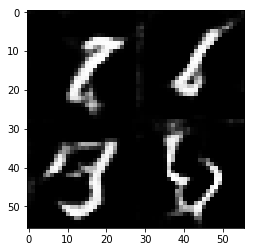

Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 1.0325... Generator Loss: 1.4420
Epoch 2/2... Discriminator Loss: 2.0129... Generator Loss: 2.5080
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 1.8136... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.5262... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 1.0226... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 1.9785... Generator Loss: 1.8747
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.4243


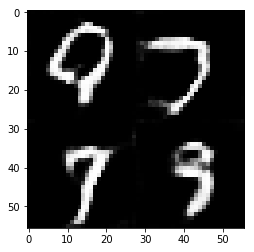

Epoch 2/2... Discriminator Loss: 1.6593... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 1.8147... Generator Loss: 1.1522
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 2.2343... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 0.8808
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 1.8629
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.8442


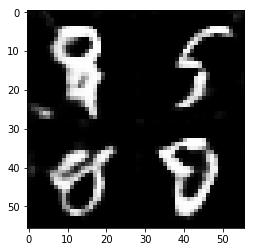

Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.9831
Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 1.8556
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.7868
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 1.3742
Epoch 2/2... Discriminator Loss: 1.6218... Generator Loss: 2.0722
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.4093
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 1.4056
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.4478


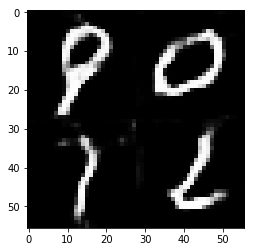

Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.3345
Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 1.8588
Epoch 2/2... Discriminator Loss: 1.7524... Generator Loss: 1.3989
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.6031
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 0.4165
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 1.8076
Epoch 2/2... Discriminator Loss: 1.6984... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 2.1613... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 1.1973


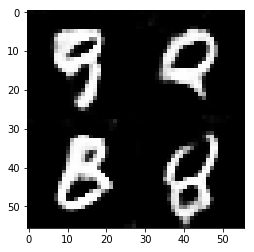

Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.5047
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.8591... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 1.8305
Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 0.4277
Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.2624
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 1.7081... Generator Loss: 1.9996


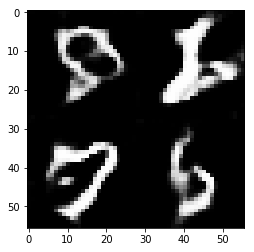

Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 2.8203... Generator Loss: 0.3997
Epoch 2/2... Discriminator Loss: 2.1091... Generator Loss: 0.3191
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 2.4621
Epoch 2/2... Discriminator Loss: 1.1928... Generator Loss: 1.1854
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 1.9545
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.7674
Epoch 2/2... Discriminator Loss: 0.6525... Generator Loss: 1.6432
Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 2.2035


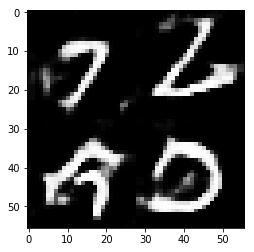

Epoch 2/2... Discriminator Loss: 2.1307... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 1.4300
Epoch 2/2... Discriminator Loss: 1.9201... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 1.6618... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 1.5138... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 1.4994


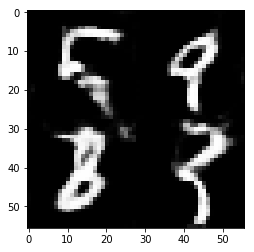

Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 2.0424... Generator Loss: 1.2870
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.6188
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 0.3207
Epoch 2/2... Discriminator Loss: 0.2623... Generator Loss: 0.9519
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.9152
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 0.3285


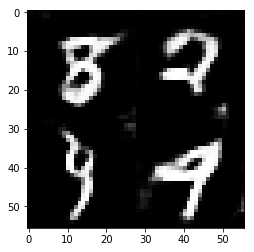

Epoch 2/2... Discriminator Loss: 1.7256... Generator Loss: 0.8337
Epoch 2/2... Discriminator Loss: 2.1437... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.6810
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 1.3450
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 2.6616
Epoch 2/2... Discriminator Loss: 1.5989... Generator Loss: 1.5507
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 1.3350
Epoch 2/2... Discriminator Loss: 2.4050... Generator Loss: 0.5163


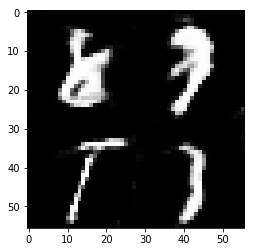

Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 0.5443
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 2.0133... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.7257... Generator Loss: 2.9991
Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 1.3417... Generator Loss: 2.4265
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 2.6919... Generator Loss: 1.8051
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.7191


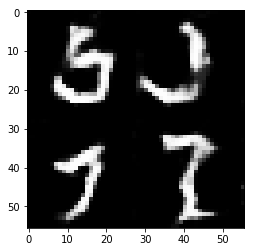

Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 2.3177
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 0.6437... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 1.5033
Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.1241
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 2.6575
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 1.1308
Epoch 2/2... Discriminator Loss: 1.6819... Generator Loss: 2.5835
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 1.0541


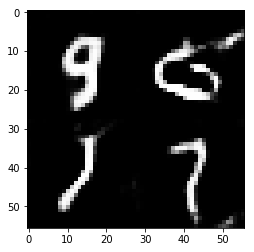

Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 1.0891
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.9599... Generator Loss: 2.2048
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 2.2090
Epoch 2/2... Discriminator Loss: 1.8009... Generator Loss: 1.7330
Epoch 2/2... Discriminator Loss: 0.5301... Generator Loss: 1.4122
Epoch 2/2... Discriminator Loss: 1.8863... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 1.8473... Generator Loss: 0.7165


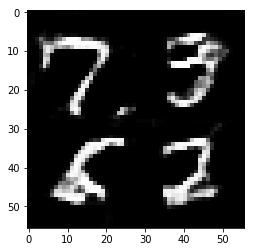

Epoch 2/2... Discriminator Loss: 2.0519... Generator Loss: 1.5052
Epoch 2/2... Discriminator Loss: 2.1476... Generator Loss: 0.2288
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.3311
Epoch 2/2... Discriminator Loss: 1.5472... Generator Loss: 1.9762
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.2025
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.7036... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 2.0161... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 1.6064... Generator Loss: 1.8305
Epoch 2/2... Discriminator Loss: 1.7457... Generator Loss: 1.1007


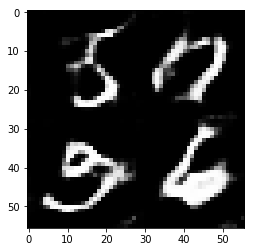

Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 2.0738
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 1.8527
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 1.9029
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 2.4096... Generator Loss: 0.3178
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.5639... Generator Loss: 0.9160
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 0.3603


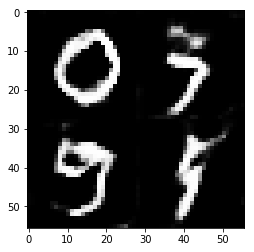

Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.1297
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 1.5993
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.5759
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 1.7532
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 2.1641
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 1.2703
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.9039
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 1.5414


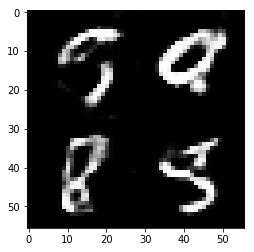

Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.8446
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 1.8456
Epoch 2/2... Discriminator Loss: 1.7280... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 2.6335... Generator Loss: 0.2952
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.6911... Generator Loss: 1.9474
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 1.8399
Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 0.6232


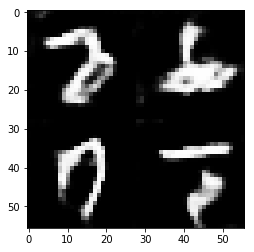

Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 2.3228
Epoch 2/2... Discriminator Loss: 1.5017... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.7652
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 2.4400
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 0.2429
Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.2232... Generator Loss: 0.3697
Epoch 2/2... Discriminator Loss: 1.6954... Generator Loss: 0.5878


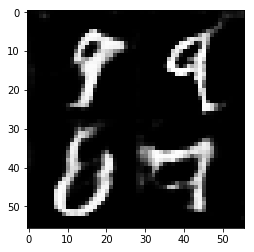

Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.7511... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 1.3667
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 1.5539
Epoch 2/2... Discriminator Loss: 1.6546... Generator Loss: 0.4933
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 1.1339
Epoch 2/2... Discriminator Loss: 1.2994... Generator Loss: 2.2967


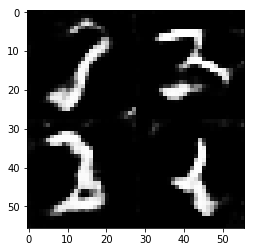

In [12]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.7890
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 2.1843
Epoch 1/1... Discriminator Loss: 0.3082... Generator Loss: 2.2507
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 2.1204
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 2.5728
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.9038
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 2.4725
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 1.4484


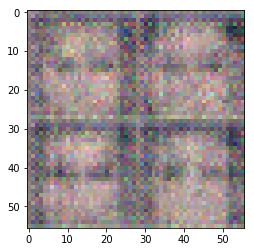

Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 2.2317
Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 2.8494
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 3.6033
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 0.3220... Generator Loss: 2.6752
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 3.0198
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 2.8245
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 3.3061
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 4.1654


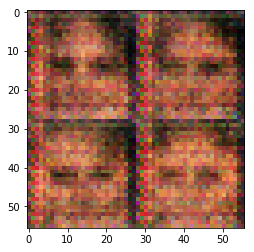

Epoch 1/1... Discriminator Loss: 0.3055... Generator Loss: 3.0668
Epoch 1/1... Discriminator Loss: 2.0181... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 4.0876
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.3618
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.9021
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 4.7144
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 3.1274
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 2.9927
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 2.6047


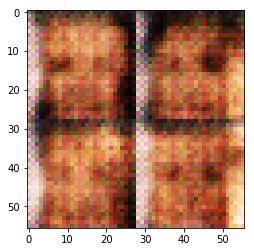

Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 3.3306
Epoch 1/1... Discriminator Loss: 2.0428... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.8943
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 2.3805
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 3.1165
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 2.5134
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 2.5423


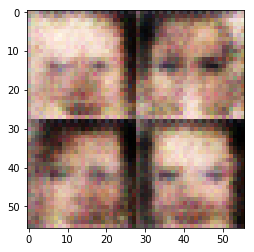

Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 2.3761
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.9198
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 2.4942
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 2.2968
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 2.0628
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 2.5537


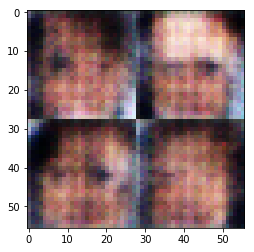

Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.8668
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.9868
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.8875
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.5503
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 2.2500
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 2.3736


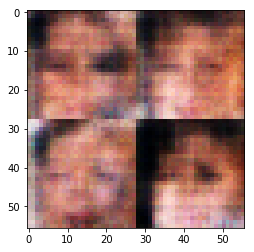

Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 2.3306
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 2.4172
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 2.4068
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 2.2238
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.8552
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 2.9959


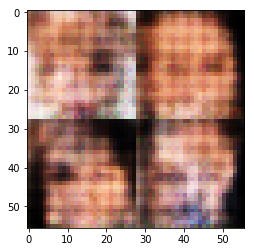

Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 3.3371
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.7760
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 2.3400
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 2.9442
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 2.2174
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.9690
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 2.8430


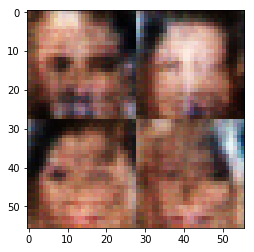

Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 2.2432
Epoch 1/1... Discriminator Loss: 1.8801... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 2.5792
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 2.0660
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.5336
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 1.6652


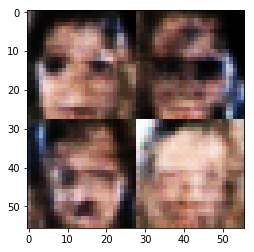

Epoch 1/1... Discriminator Loss: 0.5896... Generator Loss: 2.8159
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 2.7577
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 2.2989
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.7394
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 2.4074
Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.9462
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.8684


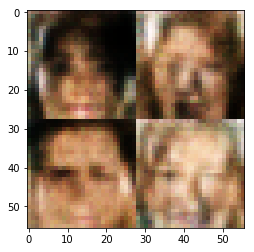

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 2.5484
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 2.1176
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 3.0894
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 3.4668
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.1096


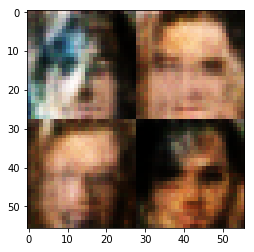

Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 2.7642
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 3.2901
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.4385
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.9478
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 2.1500
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7114


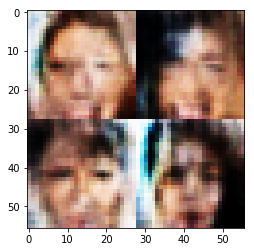

Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.4854
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.9583
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 2.2591
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 3.4837


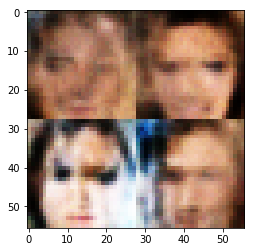

Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 2.0385
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 3.5617
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 3.5675
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 4.9151
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.7138
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 2.4734


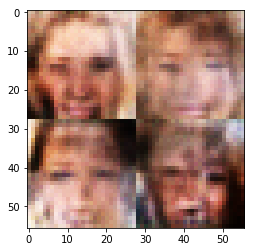

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.4479
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.6568
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.3879


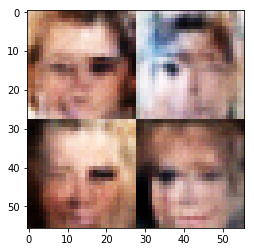

Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 3.3224
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 2.2604
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 1.4579
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.3006


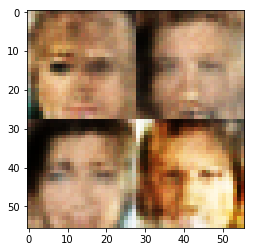

Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 2.4919
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.4096
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.8983
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 3.4766
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.8858


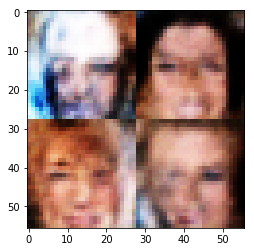

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 2.7834
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 4.2302
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.5624
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8897


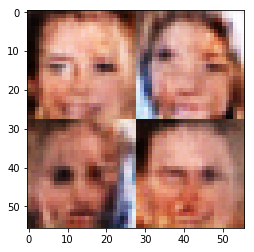

Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 2.9160
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 2.6587
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 3.2718


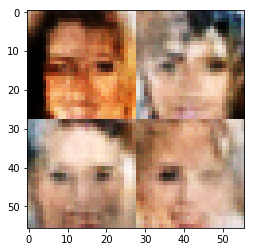

Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 2.0512
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 0.3230... Generator Loss: 3.1865
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 4.0745
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 3.7347
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 1.0619


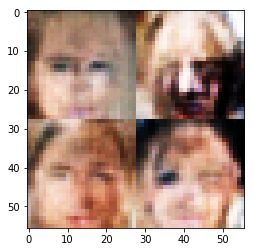

Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 3.6268
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 2.2707
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6828


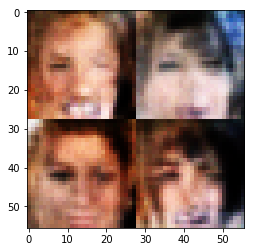

Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 1.8366
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 2.0873
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.0336


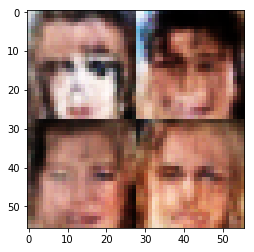

Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.5191
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.6232
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.5408
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 1.0765


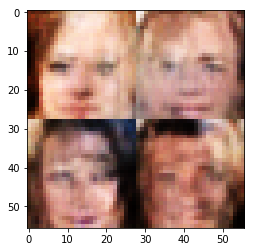

Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 3.7440
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.3555
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.8151... Generator Loss: 1.7207
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.1600


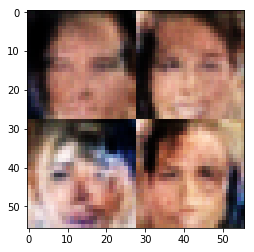

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 2.2149
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.2585
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.3702
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.7329
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 4.9538
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 3.2335


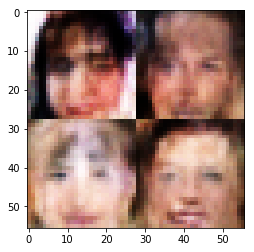

Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.3442
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 4.5881
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 2.2458
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 2.8310
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 2.3498
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.8334


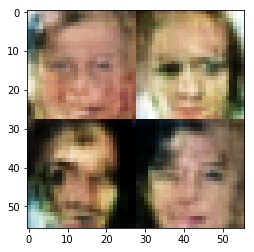

Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.4401
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 1.7001


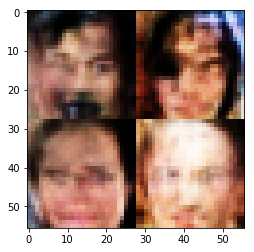

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 2.4322
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 0.2586... Generator Loss: 4.0028
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6268


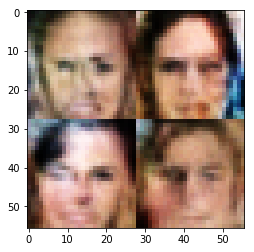

Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 3.8498
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 2.8654
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.6257... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 2.8567
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7405


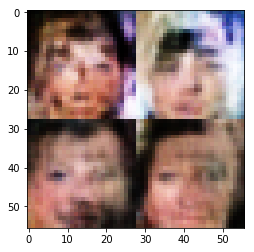

Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 6.0751
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.3397
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.8491


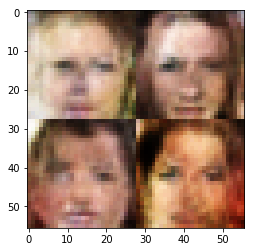

Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.7889
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 2.2372
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.4026


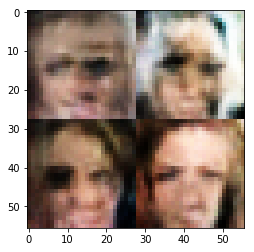

Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.5160
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 4.2016
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 2.2893
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.5946


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.